## Week 8: sequence learning


This time we'll solve a problem of transribing english words, also known as g2p (grapheme2phoneme)

 * word (sequence of letters in source language) -> translation (sequence of letters in target language)


 
Some letters correspond to several phonemes and others - to none, so we use encoder-decoder architecture to figure that out.

This kind of architectures is about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts
 
 
We chose simplified __Hebrew->English__ machine translation for words and short phrases (character-level), as it is relatively quick to train even without gpu cluster.

Since you have already done step1-2 in RNN assignment, we trust you to __read carefully__ through already implemented functions instead of reimplementing them for the third time.

__Contributions:__ This notebook is brought to you by
* Yandex [MT team](https://tech.yandex.com/translate/)
* Oleg Vasilev ([Omrigan](https://github.com/Omrigan/)), Dmitry Emelyanenko ([TixFeniks](https://github.com/tixfeniks)) and Fedor Ratnikov ([justheuristic](https://github.com/justheuristic/))
* Dataset is parsed from [Wiktionary](https://en.wiktionary.org), which is under CC-BY-SA and GFDL licenses.


In [1]:
EASY_MODE = True        #If True, only translates phrases shorter than 20 characters (way easier).
                        #Useful for initial coding.
                        #If false, works with all phrases (please switch to this mode for homework assignment)

MODE = "he-to-en"                                #way we translate. Either "he-to-en" or "en-to-he"
END = ';'                                        #end of phrase for both source and target
MAX_OUTPUT_LENGTH = 50 if not EASY_MODE else 20  #maximal length of _generated_ output, does not affect training
REPORT_FREQ       = 100                          #how often to evaluate validation score


### Step 1: preprocessing

We shall store dataset as a dictionary
`{ word1:[translation1,translation2,...], word2:[...],...}`.

This is mostly due to the fact that many words have several correct translations.

In [2]:
import numpy as np
from collections import defaultdict
word_to_translation = defaultdict(list) #our dictionary

with open("main_dataset.txt", encoding='UTF-8') as fin:
    for line in fin:
        
        ###
        #you may want to cast everything to unicode later during homework phase, just make sure you do it _everywhere_
        ###

        en, he = line[:-1].lower().replace(END, ' ').split('\t')
        word, trans = (he, en) if MODE == 'he-to-en' else (en, he)
                
        if EASY_MODE:
            if max(len(word), len(trans)) > 20:
                continue
        
        word_to_translation[word+END].append(trans+END)

print ("size = ", len(word_to_translation))

size =  130699


In [3]:
#get all unique letters in source language (a.k.a. source dictionary)
all_words = list(word_to_translation.keys())

source_letters = list(set(''.join(all_words)))
source_to_ix = {l: i for i, l in enumerate(source_letters)}

In [4]:
type(all_words)

list

In [5]:
#get all unique translation letters (a.k.a. target dictionary)

all_translations = [ts for all_ts in word_to_translation.values() for ts in all_ts]

target_letters = list(set([l for ts in all_translations for l in ts]+[" "]))
target_to_ix = {l:i for i, l in enumerate(target_letters)}

In [6]:
#Special tokens
PAD_ix = -1
EOS_ix_source = source_letters.index(END)
EOS_ix_target = target_letters.index(END)
BOS_ix_target = target_letters.index(" ")

Draw word/translation length distributions to estimate the scope of the task.

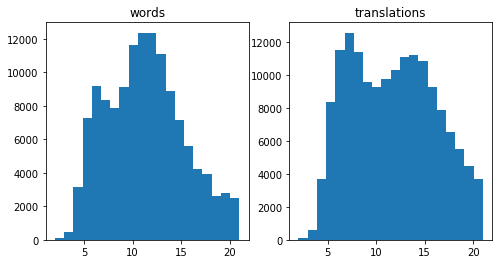

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.title("words")
plt.hist(list(map(len, all_words)), bins=20);

plt.subplot(1,2,2)
plt.title('translations')
plt.hist(list(map(len, all_translations)), bins=20);


### Step 2: auxiliary functions

we need some helper functions that
* convert data from strings to integer matrices
* sample random minibatches

In [8]:
def as_matrix(sequences, token_to_i, max_len=None, PAX_ix=PAD_ix):
    """
    convert variable length token sequences into  fixed size matrix
    example usage: 
    >>>print( as_matrix(words[:3],source_to_ix))
    [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
     [30 21 15 15 21 14 28 27 13 -1 -1]
     [25 37 31 34 21 20 37 21 28 19 13]]
    """
    max_len = max_len or max(map(len, sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + PAD_ix
    for i, seq in enumerate(sequences):
        row_ix = list(map(token_to_i.get, seq))[:max_len]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [9]:
import random
def sample_batch(words, word_to_translation, batch_size):
    """
    sample random batch of words and random correct translation for each word
    example usage:
    batch_x,batch_y = sample_batch(train_words, word_to_translations,10)
    """
    
    #choose words
    batch_words = np.random.choice(words, size=batch_size)
    
    #choose translations
    batch_trans_candidates = list(map(word_to_translation.get, batch_words))
    batch_trans = list(map(random.choice, batch_trans_candidates))
    
    return as_matrix(batch_words, source_to_ix), as_matrix(batch_trans, target_to_ix)

### split the dataset

We hold out 20% of all words to be used for validation.


In [10]:
from sklearn.cross_validation import train_test_split

train_words, test_words = train_test_split(all_words, test_size=0.1, random_state=42)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Step 3: Build encoder-decoder (1 point)

__assignment starts here__

Our architecture consists of two main blocks:
* Encoder reads words character by character and outputs code vector (usually a function of last RNN state)
* Decoder takes that code vector and produces translations character by character

In this section, we'll implement __encoder__ the same way you did for week6.5.

In [11]:
%env THEANO_FLAGS=device=cpu, floatX=float32
import theano
import theano.tensor as T

import lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=cpu, floatX=float32


One more note: in this assignment, we'll be using classes as namespaces:

```
class my_pocket:
    coin = "$"
    coins = coin*3
    mobile = "nokia 3310"
    
>>>print my_pocket.coins
$$$
>>>print my_pocket.mobile
nokia 3310
```


Your first assignment is to implement encoder network using lasagne layers.

In [12]:
def get_mask_by_eos(is_eos):
    """takes indicator of "it ends now", returns mask.
    Ignores everything after first end."""
    assert is_eos.ndim == 2
    is_right_after_eos = T.concatenate([T.zeros_like(is_eos[:,:1]), is_eos[:,:-1]], -1)
    is_after_eos = T.eq(T.cumsum(is_right_after_eos, axis=-1), 0).astype('uint8')
    return is_after_eos

In [13]:
class encoder:
    """encoder rnn"""
    
    #input tokens and mask
    input_sequence = T.matrix('token sequence', 'int32')
    input_mask = get_mask_by_eos(T.eq(input_sequence, EOS_ix_source))
    
    inp = InputLayer(shape=(None, None), input_var=input_sequence, name='encoder input')
    inp_mask = InputLayer(shape=(None, None), input_var=input_mask, name='encoder input mask')
    
    #embedding
    emb = EmbeddingLayer(inp,
                         input_size=len(source_letters),
                         output_size=50)
    
    #encoder rnn
    rnn = GRULayer(incoming=emb,
                   num_units=512,
                   mask_input=inp_mask)
    
    #slice last time-step of encoder rnn
    rnn_last = SliceLayer(rnn, -1, axis=1, name='last rnn time-step')
    
    #compute decoder initial state
    code = DenseLayer(rnn_last, 512, nonlinearity=T.tanh)

#### Decoder

In this section, we will define __one step__ of decoder (just like we defined one step of agent last week).


In [14]:
from agentnet.memory import RNNCell, GRUCell, LSTMCell
from agentnet.resolver import ProbabilisticResolver

In [15]:
class decoder:
    """single step of decoder rnn"""
    
    inp = InputLayer((None,), name="prev phoneme")
    
    emb = EmbeddingLayer(inp, len(target_letters), 50)
    
    #decoder memory
    prev_gru = InputLayer((None, 512))
    
    gru = GRUCell(prev_gru, emb) #use shift-tab to figure out what goes here
    
    logits = DenseLayer(gru, len(target_letters), nonlinearity=None)
    
    #probabilities
    probs = NonlinearityLayer(logits, T.nnet.softmax)
    
    #output phonemes
    out = ProbabilisticResolver(probs, assume_normalized=True)
    
    #log-probabilities
    logprobs = NonlinearityLayer(logits, T.nnet.logsoftmax)
    

## Wire it all together (1 point)

Here we define functions for model _inference_ (both greedy and sampled).

In [16]:
from agentnet import Recurrence
from collections import OrderedDict as od
class model:
    #maximum output length for inference
    n_steps = theano.shared(MAX_OUTPUT_LENGTH)
    
    #initial inputs: indices of "START" special phoneme.
    l_start = InputLayer((None,), T.zeros_like(encoder.input_sequence[:, 0])+BOS_ix_target)

    #Here we define recurrence: it's a custom recurrent layer, acting exactly like Agent, 
    #except it's a lasagne layer.
    
    rec = Recurrence(
        #recurrent states
        state_variables=od({decoder.gru: decoder.prev_gru,
                            decoder.out: decoder.inp}),
        
        #initial values for recurrent states
        state_init={decoder.gru: encoder.code,
                    decoder.out: l_start},
        
        tracked_outputs=(decoder.out, decoder.probs, decoder.logprobs),
        unroll_scan=False,
        n_steps=n_steps
    )
    
    weights = get_all_params(rec, trainable=True)
    
    
    #sample mode
    predicted_translations, probs_seq, logprobs_seq = get_output(rec[decoder.out, decoder.probs, decoder.logprobs])
    auto_updates = rec.get_automatic_updates()

    #output mask
    mask = get_mask_by_eos(T.eq(predicted_translations, EOS_ix_target))
    
    generate_sample = theano.function([encoder.input_sequence],
                                      predicted_translations,
                                      updates=auto_updates)
    
    #greedy mode (picking max-probability actions on each step)
    greedy_translations = get_output(rec[decoder.out], recurrence_flags={"greedy": True})
    greedy_auto_updates = rec.get_automatic_updates()
    
    greedy_mask = get_mask_by_eos(T.eq(greedy_translations, EOS_ix_target))
    
    
    generate_greedy = theano.function([encoder.input_sequence],
                                      greedy_translations,
                                      updates=greedy_auto_updates)
    

    @staticmethod
    def translate(word, sample=False):
        assert word.endswith(END)
        
        #convert to matrix
        word_ix = as_matrix([word.lower()], source_to_ix)
        
        #generate output
        if sample:
            trans_ix = model.generate_sample(word_ix)[0]
        else:
            trans_ix = model.generate_greedy(word_ix)[0]
        
        #convert from int32 to string
        trans = list(map(target_letters.__getitem__, trans_ix))
        
        #crop padding
        if END in trans:
            trans = trans[:trans.index(END)+1]
            
        return ''.join(trans)        


In [17]:
#test untrained model
#should be random
print('x:' + all_words[0])
print('y_sampled:' + model.translate(all_words[0], sample=True))
print('y_greedy:' + model.translate(all_words[0]))

#praise Cthulhu!

x:where are you?;
y_sampled:קկлĵいפ♭כýćɱпнδäħsŋ2ł
y_greedy:ţ0עעááהţ≤ãصãhμhρģ♭♭→


### Scoring function

LogLikelihood is a poor estimator of model performance.
* If we predict zero probability once, it shouldn't ruin entire model.
* It is enough to learn just one translation if there are several correct ones.
* What matters is which output will we produce if we __take most likely phoneme on each step.__

Therefore, we will use minimal Levenshtein distance.


In [18]:
import editdistance #!pip install editdistance

def get_distance(word, trans):
    """
    A function that takes word and predicted translation
    and evaluates (Levenshtein's) edit distance to closest correct translation
    """
    references = word_to_translation[word]
    assert len(references)!=0, "wrong/unknown word"
    return min(editdistance.eval(trans, ref) for ref in references)

In [19]:
def score(bsize=100):
    """a function that computes levenshtein distance for bsize random samples"""
    
    batch_words = np.random.choice(test_words, size=bsize)
    
    trans = [model.translate(word, sample=False) for word in batch_words]
    distances = [get_distance(word, tran) for word, tran in zip(batch_words, trans)]
    
    return np.array(distances, dtype='float32')

In [20]:
#should be around 5-50 and decrease rapidly :)
[score(100).mean() for _ in range(10)]

[19.57,
 19.790001,
 19.790001,
 19.629999,
 19.780001,
 19.780001,
 19.74,
 19.74,
 19.690001,
 19.719999]

## Step 4: Supervised pre-training

Here we define a function that trains our model through maximizing log-likelihood a.k.a. minimizing crossentropy.

In [21]:
from agentnet.learning.generic import get_values_for_actions

class llh_trainer:

    #variable for correct answers
    reference_answers = T.imatrix("reference translations")
    
    #shift 1 step to the past to get "previous answers"
    prev_answers = T.concatenate([T.zeros_like(reference_answers[:,:1])+BOS_ix_target,
                                  reference_answers[:,:-1]], axis=1)
    
    #mask on prev answers
    input_mask = get_mask_by_eos(T.eq(prev_answers, EOS_ix_target))
    
    #create input layers
    l_sequence = InputLayer((None, None), prev_answers)
    l_mask = InputLayer((None, None), input_mask)
    
    #teacher-forced trainer
    rec = Recurrence(state_variables=od({decoder.gru: decoder.prev_gru}),
                     input_sequences={decoder.inp: l_sequence},
                     state_init={decoder.gru: encoder.code},
                     tracked_outputs=(decoder.probs, decoder.logprobs),
                     unroll_scan=False,
                     mask_input=l_mask)
    
    
    #get log-probabilities
    logprobs_seq = get_output(rec[decoder.logprobs])
    auto_updates = rec.get_automatic_updates()
    
    #compute mean crossentropy
    crossentropy = -get_values_for_actions(logprobs_seq, reference_answers)
    
    loss = T.sum(crossentropy*input_mask)/T.sum(input_mask)
    
    #get all params
    weights = get_all_params(rec, trainable=True)

    #weight updates                 
    updates = lasagne.updates.adam(loss, weights, learning_rate=0.001)
    
    train_step = theano.function([encoder.input_sequence, reference_answers],
                                 loss,
                                 updates=auto_updates+updates)
    

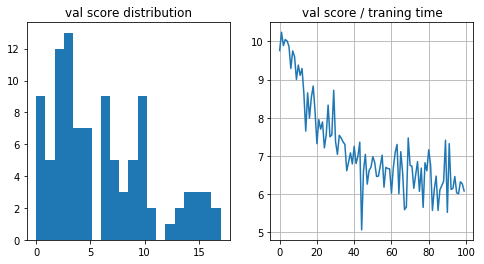

100%|██████████| 10000/10000 [1:58:55<00:00,  2.76s/it]

llh=1.040, mean score=6.228


In [22]:
from IPython.display import clear_output
from tqdm import tqdm,trange #or use tqdm_notebook,tnrange

loss_history=[]
editdist_history = []

for i in trange(10000):
    loss_history.append(
            llh_trainer.train_step(*sample_batch(train_words, word_to_translation, 32)))
    
    if (i+1)%REPORT_FREQ==0:
        clear_output(True)
        current_scores = score()
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(8,4))
        plt.subplot(121)
        plt.title('val score distribution')
        plt.hist(current_scores, bins=20)
        plt.subplot(122)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("llh=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:])))

In [23]:
for word in train_words[:10]:
    print("%s -> %s"%(word, model.translate(word)))

מישלינג; -> mishleng;
vh1; -> vhv;
בארלטה; -> barlatta;
קטגוריה:user oc-2; -> user u22;
קופרטינו; -> copertino;
מישה סגל; -> misha segal;
שנקרה; -> shankara;
עפרן; -> paral;
קטגוריה:מונדיאל 1930; -> 1930 fifa world cup;
ג'ורג' מרשל; -> george marshall;


## Step 5: Policy gradient (3 pts)

First we need to define loss function as a custom theano operation.

The simple way to do so is
```
@theano.compile.as_op(input_types,output_type(s),infer_shape)
def my_super_function(inputs):
    return outputs
```




__Your task__ is to implement `_compute_levenshtein` function that takes matrices of words and translations, along with input masks, then converts those to actual words and phonemes and computes min-levenshtein via __get_distance__ function above.


In [24]:
@theano.compile.as_op([T.imatrix]*4, [T.fvector], lambda _, shapes: [shapes[0][:1]])
def _compute_levenshtein(words_ix, words_mask, trans_ix, trans_mask):
    """
    A custom theano operation that computes levenshtein loss for predicted trans.
    
    Params:
    - words_ix - a matrix of letter indices, shape=[batch_size, word_length]
    - words_mask - a matrix of zeros/ones, 
       1 means "word is still not finished"
       0 means "word has already finished and this is padding"
    
    - trans_ix - a matrix of output letter indices, shape=[batch_size, translation_length]
    - trans_mask - a matrix of zeros/ones, similar to words_mask but for trans_ix
    
    
    Please implement the function and make sure it passes tests from the next cell.
    
    """
    
    #convert words to strings
    # <your code here>
    length = np.sum(words_mask, axis=1)
    words = [[source_letters[ix] for ix in row] for row in words_ix]
    words = ["".join(row[:length[i]]) for i, row in enumerate(words)]

    assert type(words) is list
    assert type(words[0]) is str 
    assert len(words)==len(words_ix)
    
    #convert translations to lists
    # <your code here>
    length = np.sum(trans_mask, axis=1)
    translations = [[target_letters[ix] for ix in row] for row in trans_ix]
    translations = ["".join(row[:length[i]]) for i, row in enumerate(translations)]

    assert type(translations) is list
    assert type(translations[0]) is str
    assert len(translations)==len(trans_ix)

    #computes levenstein distances. can be arbitrary python code.
    distances = [get_distance(word, trans) for word, trans in zip(words, translations)]
    
    assert type(distances) in (list, tuple, np.ndarray) and len(distances) == len(words_ix)
    
    distances = np.array(list(distances), dtype='float32')
    return distances

#forbid gradient
from theano.gradient import disconnected_grad
def compute_levenshtein(*args):
    return disconnected_grad(_compute_levenshtein(*[arg.astype('int32') for arg in args]))

Simple test suite to make sure your implementation is correct. Hint: if you run into any bugs, feel free to use print from inside _compute_levenshtein.

In [25]:
#test suite
#sample random batch of (words, correct trans, wrong trans)
batch_words = np.random.choice(train_words, size=100 )
batch_trans = list(map(random.choice, map(word_to_translation.get, batch_words )))
batch_trans_wrong = np.random.choice(all_translations, size=100)

batch_words_ix = T.constant(as_matrix(batch_words, source_to_ix))
batch_trans_ix = T.constant(as_matrix(batch_trans, target_to_ix))
batch_trans_wrong_ix = T.constant(as_matrix(batch_trans_wrong, target_to_ix))

batch_words_mask = get_mask_by_eos(T.eq(batch_words_ix, EOS_ix_source))
batch_trans_mask = get_mask_by_eos(T.eq(batch_trans_ix, EOS_ix_target))
batch_trans_wrong_mask = get_mask_by_eos(T.eq(batch_trans_wrong_ix, EOS_ix_target))


In [26]:
#assert compute_levenshtein is zero for ideal translations
correct_answers_score = compute_levenshtein(batch_words_ix,
                                            batch_words_mask,
                                            batch_trans_ix,
                                            batch_trans_mask).eval()

assert np.all(correct_answers_score==0), "a perfect translation got nonzero levenshtein score!"

print("Everything seems alright!")

Everything seems alright!


In [27]:
#assert compute_levenshtein matches actual scoring function
wrong_answers_score = compute_levenshtein(batch_words_ix,batch_words_mask,
                                            batch_trans_wrong_ix,batch_trans_wrong_mask).eval()

true_wrong_answers_score = np.array(list(map(get_distance, batch_words,batch_trans_wrong)))

assert np.all(wrong_answers_score==true_wrong_answers_score),"for some word symbolic levenshtein is different from actual levenshtein distance"

print("Everything seems alright!")

Everything seems alright!


Once you got it working...


* You may now want to __remove/comment asserts__ from function code for a slight speed-up.

* There's a more detailed tutorial on custom theano ops here: [docs](http://deeplearning.net/software/theano/extending/extending_theano.html), [example](https://gist.github.com/justheuristic/9f4ffef6162a8089c3260fc3bbacbf46).

## Self-critical policy gradient

In this section you'll implement algorithm called self-critical sequence training (here's an [article](https://arxiv.org/abs/1612.00563)).

The algorithm is a vanilla policy gradient with a special baseline. 

$$ \nabla J = E_{x \sim p(s)} E_{y \sim \pi(y|x)} \nabla log \pi(y|x) \cdot (R(x,y) - b(x)) $$

Here reward R(x,y) is a __negative levenshtein distance__ (since we minimize it). The baseline __b(x)__ represents how well model fares on word __x__.

In practice, this means that we compute baseline as a score of greedy translation, $b(x) = R(x,y_{greedy}(x)) $.

Luckily, we already obtained the required outputs: `model.greedy_translations, model.greedy_mask` and we only need to compute levenshtein using `compute_levenshtein` function.


In [28]:
from agentnet.learning.generic import get_values_for_actions

class trainer:    
    
    rewards = -compute_levenshtein(encoder.input_sequence,
                                   encoder.input_mask,
                                   model.predicted_translations,
                                   model.mask)
    
    baseline = -compute_levenshtein(encoder.input_sequence,
                                    encoder.input_mask,
                                    model.greedy_translations,
                                    model.greedy_mask)
    
    #compute advantage using rewards and baseline
    advantage = rewards - baseline
    
    
    #compute log_pi(a_t|s_t), shape = [batch, seq_length]
    phoneme_logprobs = get_values_for_actions(model.logprobs_seq, model.predicted_translations)
    
    #policy gradient
    J = phoneme_logprobs*advantage[:, None]
    
    loss = -T.sum(J*model.mask) / model.mask.sum()
    
    
    #regularize with negative entropy
    #note: you can find full policy distribution in model.probs_seq and similar
    entropy = -model.probs_seq*model.logprobs_seq
    entropy = entropy.sum(axis=-1)

    loss -= 0.01*(model.mask*entropy).sum() / model.mask.sum()
    
    
    # Compute weight updates, clip by norm
    grads = T.grad(loss,model.weights)
    grads = lasagne.updates.total_norm_constraint(grads, 10)

    updates = lasagne.updates.adam(grads, model.weights, learning_rate=1e-5) 

    train_step = theano.function([encoder.input_sequence], loss,
                                 updates = model.auto_updates+model.greedy_auto_updates+updates)
    
    
    
    

# Policy gradient training


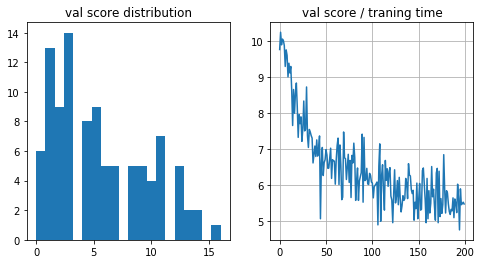

100%|██████████| 10000/10000 [2:22:20<00:00,  2.87s/it]

J=-1.011, mean score=5.493


In [29]:
for i in trange(10000):
    loss_history.append(
        trainer.train_step(sample_batch(train_words, word_to_translation, 32)[0])
    )
    
    if (i+1)%REPORT_FREQ==0:
        clear_output(True)
        current_scores = score()
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(8,4))
        plt.subplot(121)
        plt.title('val score distribution')
        plt.hist(current_scores, bins=20)
        plt.subplot(122)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("J=%.3f, mean score=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:])))

In [30]:
model.translate("EXAMPLE;")

'esexpel;'

### Results

100%|██████████| 13070/13070 [13:40<00:00, 16.47it/s]


Mean Levenshtein distance: 5.68722264728
Median Levenshtein distance: 5.0


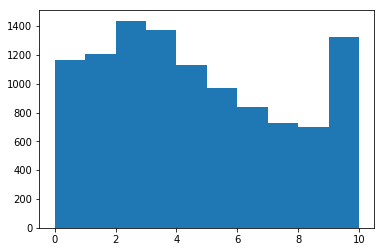

In [31]:
predicted_translations = list(map(model.translate, tqdm(test_words)))
distances = list(map(get_distance, test_words,predicted_translations))
print ("Mean Levenshtein distance:", np.mean(distances))
print ("Median Levenshtein distance:", np.median(distances))
plt.hist(distances, range=[0,10]);

## Step 6: Make it actually work (5++ pts)

In this section we want you to finally __restart with EASY_MODE=False__ and experiment to find a good model/curriculum for that task.

We recommend the following architecture

```
encoder---decoder

           P(y|h)
             ^
 LSTM  ->   LSTM
  ^          ^
 LSTM   ->  LSTM
  ^          ^
input       y_prev
```

with __both__ LSTMs having equal or more units than the default gru.


It's okay to modify the code above without copy-pasting it.

__Some tips:__
* You will likely need to adjust pre-training time for such a network.
* Supervised pre-training may benefit from clipping gradients somehow.
* SCST may indulge a higher learning rate in some cases and changing entropy regularizer over time.
* There's more than one way of sending information from encoder to decoder, especially if there's more than one layer:
  * __Vanilla:__ layer_i of encoder last state goes to layer_i of decoder initial state
  * __Intermediate layers:__ add dense (and possibly concat) layers between encoder last and decoder first.
  * __Every tick:__ feed encoder last state _on every iteration_ of decoder.


* It's often useful to save pre-trained model parameters to not re-train it every time you want new policy gradient parameters. 
* When leaving training for nighttime, try setting REPORT_FREQ to a larger value (e.g. 500) not to waste time on it.


* (advanced deep learning) It may be a good idea to first train on small phrases and then adapt to larger ones (a.k.a. training curriculum).
* (advanced nlp) You may want to switch from raw utf8 to something like unicode or even syllables to make task easier.
* (advanced nlp) Since hebrew words are written __with vowels omitted__, you may want to use a small Hebrew vowel markup dataset at `he-pron-wiktionary.txt`.

__Formal criteria__:

To get 5 points we want you to build an architecture that:
* _doesn't consist of single GRU_
* _works better_ than single GRU baseline. 
* We also want you to provide either learning curve or trained model, preferably both
* ... and write a brief report or experiment log describing what you did and how it fared.

`[your report/log here or anywhere you please]`

### Bonus assignments: [here](https://github.com/yandexdataschool/Practical_RL/blob/master/week8/8.2_bonus.ipynb)